In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#**Import**

In [2]:
import pandas as pd
import glob
import datetime as dt
import multiprocessing as mp
from datetime import datetime
import numpy as np
import plotly
from pandas import Series
import sys
from scipy import stats

from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm, tqdm_notebook
import time



import plotly.io as pio

!pip install plotly==5.3.1
!pip install -U kaleido

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

!pip install pyfolio
import pyfolio as pf

from scipy.stats import weightedtau

import os
from sklearn.pipeline import Pipeline


# For sending GET requests from the API
import requests

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [3]:
cd gdrive/My Drive/TFM/

/content/gdrive/My Drive/TFM


In [4]:
# raw trade data from https://public.bitmex.com/?prefix=data/trade/ 
Dollar_bars = pd.DataFrame()
for i,file in enumerate(glob.glob("data/bars/new_features/*.csv")):
  if i == 0:
    Dollar_bars = Dollar_bars.append(pd.read_csv(file))
    print('Percentge of files already Loaded:',round((i/len(glob.glob("data/bars/new_features/*.csv")))*100,1), '%. There are', len(glob.glob("data/bars/new_features/*.csv"))-i,
          "files left", end='')
  else:
    Dollar_bars = Dollar_bars.append(pd.read_csv(file))
    print('\r Percentge of files already Loaded:',round((i/len(glob.glob("data/bars/new_features/*.csv")))*100,1), '%. There are', len(glob.glob("data/bars/new_features/*.csv"))-i,
          "files left",end='', flush=True)

Percentge of files already Loaded: 0.0 %. There are 1 files left

In [5]:
Dollar_bars['timestamp'] = Dollar_bars.timestamp.map(lambda t: datetime.strptime(t, "%Y-%m-%d %H:%M:%S.%f"))
Dollar_bars.set_index('timestamp', inplace=True)
Dollar_bars

,Unnamed: 0,open,high,low,close,grossValue,homeNotional,foreignNotional,tweet_count,tweet_count2,Google_trend1,timestamp.1,Google_trend2
timestamp,,,,,,,,,,,,,
2019-12-22 00:00:02.857537,0,126.95,127.60,126.90,127.00,133995088605,75212.579042,9.563766e+06,379.0,172.0,42.0,2019-12-22 00:00:02.857537,55.0
2019-12-22 06:51:01.172756,1,127.00,128.80,126.95,128.45,133739653760,74811.562495,9.556766e+06,376.0,204.0,51.0,2019-12-22 06:51:01.172756,70.0
2019-12-22 07:42:27.825653,2,128.45,129.50,128.25,129.50,133638036400,74270.069115,9.573891e+06,609.0,359.0,56.0,2019-12-22 07:42:27.825653,58.0
2019-12-22 07:57:26.330204,3,129.50,131.45,129.40,130.45,132643814650,73244.938417,9.539001e+06,609.0,359.0,56.0,2019-12-22 07:57:26.330204,58.0
2019-12-22 08:02:58.674871,4,130.45,130.55,128.85,129.00,133612879225,73900.574533,9.580523e+06,737.0,211.0,55.0,2019-12-22 08:02:58.674871,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-23 22:32:07.348209,24909,2091.35,2115.05,2065.90,2065.95,27670542430,4552.292856,9.452077e+06,3903.0,2226.0,74.0,2021-05-23 22:32:07.348209,41.0
2021-05-23 22:50:54.588234,24910,2065.95,2075.10,2060.00,2065.00,28421512785,4657.210306,9.631046e+06,3903.0,2226.0,74.0,2021-05-23 22:50:54.588234,41.0
2021-05-23 22:53:52.767283,24911,2065.00,2104.25,2065.00,2090.00,28385242445,4636.918646,9.626955e+06,3903.0,2226.0,74.0,2021-05-23 22:53:52.767283,41.0


#**class and method definition**

##Multiprocessing

In [6]:
class MultiProcessingFunctions:
	""" This static functions in this class enable multi-processing"""
	def __init__(self):
		pass

	@staticmethod
	def lin_parts(num_atoms, num_threads):
		""" This function partitions a list of atoms in subsets (molecules) of equal size.
		An atom is a set of indivisible set of tasks.
		"""

		# partition of atoms with a single loop
		parts = np.linspace(0, num_atoms, min(num_threads, num_atoms) + 1)
		parts = np.ceil(parts).astype(int)
		return parts

	@staticmethod
	def nested_parts(num_atoms, num_threads, upper_triangle=False):
		""" This function enables parallelization of nested loops.
		"""
		# partition of atoms with an inner loop
		parts = []
		num_threads_ = min(num_threads, num_atoms)

		for num in range(num_threads_):
			part = 1 + 4 * (parts[-1] ** 2 + parts[-1] + num_atoms * (num_atoms + 1.) / num_threads_)
			part = (-1 + part ** .5) / 2.
			parts.append(part)

		parts = np.round(parts).astype(int)

		if upper_triangle:  # the first rows are heaviest
			parts = np.cumsum(np.diff(parts)[::-1])
			parts = np.append(np.array([0]), parts)
		return parts

	@staticmethod
	def mp_pandas_obj(func, pd_obj, num_threads=24, mp_batches=1, lin_mols=True, **kargs):
		"""	
		:param func: (string) function to be parallelized
		:param pd_obj: (vector) Element 0, is name of argument used to pass the molecule;
						Element 1, is the list of atoms to be grouped into a molecule
		:param num_threads: (int) number of threads
		:param mp_batches: (int) number of batches
		:param lin_mols: (bool) Tells if the method should use linear or nested partitioning
		:param kargs: (var args)
		:return: (data frame) of results
		"""

		if lin_mols:
			parts = MultiProcessingFunctions.lin_parts(len(pd_obj[1]), num_threads * mp_batches)
		else:
			parts = MultiProcessingFunctions.nested_parts(len(pd_obj[1]), num_threads * mp_batches)

		jobs = []
		for i in range(1, len(parts)):
			job = {pd_obj[0]: pd_obj[1][parts[i - 1]:parts[i]], 'func': func}
			job.update(kargs)
			jobs.append(job)

		if num_threads == 1:
			out = MultiProcessingFunctions.process_jobs_(jobs)
		else:
			out = MultiProcessingFunctions.process_jobs(jobs, num_threads=num_threads)

		if isinstance(out[0], pd.DataFrame):
			df0 = pd.DataFrame()
		elif isinstance(out[0], pd.Series):
			df0 = pd.Series()
		else:
			return out

		for i in out:
			df0 = df0.append(i)

		df0 = df0.sort_index()
		return df0

	@staticmethod
	def process_jobs_(jobs):
		""" Run jobs sequentially, for debugging """
		out = []
		for job in jobs:
			out_ = MultiProcessingFunctions.expand_call(job)
			out.append(out_)
		return out

	@staticmethod
	def expand_call(kargs):
		""" Expand the arguments of a callback function, kargs['func'] """
		func = kargs['func']
		del kargs['func']
		out = func(**kargs)
		return out

	@staticmethod
	def report_progress(job_num, num_jobs, time0, task):
		# Report progress as asynch jobs are completed

		msg = [float(job_num) / num_jobs, (time.time() - time0)/60.]
		msg.append(msg[1] * (1/msg[0] - 1))
		time_stamp = str(dt.datetime.fromtimestamp(time.time()))

		msg = time_stamp + ' ' + str(round(msg[0]*100, 2)) + '% '+task+' done after ' + \
			str(round(msg[1], 2)) + ' minutes. Remaining ' + str(round(msg[2], 2)) + ' minutes.'

		if job_num < num_jobs:
			sys.stderr.write(msg+'\r')
		else:
			sys.stderr.write(msg+'\n')

		return

	@staticmethod
	def process_jobs(jobs, task=None, num_threads=24):
		""" Run in parallel. jobs must contain a 'func' callback, for expand_call"""

		if task is None:
			task = jobs[0]['func'].__name__

		pool = mp.Pool(processes=num_threads)
		# outputs, out, time0 = pool.imap_unordered(MultiProcessingFunctions.expand_call,jobs),[],time.time()
		outputs = pool.imap_unordered(MultiProcessingFunctions.expand_call, jobs)
		out = []
		time0 = time.time()

		# Process asyn output, report progress
		for i, out_ in enumerate(outputs, 1):
			out.append(out_)
			MultiProcessingFunctions.report_progress(i, len(jobs), time0, task)

		pool.close()
		pool.join()  # this is needed to prevent memory leaks
		return out

##RSI and BBANDS

In [7]:
def relative_strength_index(df, n):
        """Calculate Relative Strength Index(RSI) for given data.
        https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py
        
        :param df: pandas.DataFrame
        :param n: 
        :return: pandas.DataFrame
        """
        i = 0
        UpI = [0]
        DoI = [0]
        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0
            UpI.append(UpD)
            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0
            DoI.append(DoD)
            i = i + 1
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
        RSI = pd.Series(round(PosDI * 100. / (PosDI + NegDI)), name='RSI_' + str(n))
        # df = df.join(RSI)
        return RSI

In [8]:
def bbands(close_prices, window, no_of_stdev):
    # rolling_mean = close_prices.rolling(window=window).mean()
    # rolling_std = close_prices.rolling(window=window).std()
    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

##Meta-labeling methods

In [9]:
#SNIPPET 3.1 DAILY VOLATILITY ESTIMATES

def get_daily_vol(close, lookback=100):
    """
    :param close: (data frame) Closing prices
    :param lookback: (int) lookback period to compute volatility
    :return: (series) of daily volatility value
    """
    print('Calculating daily volatility for dynamic thresholds')
    
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = (pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:]))
        
    df0 = close.loc[df0.index] / close.loc[df0.values].values - 1  # daily returns
    df0 = df0.ewm(span=lookback).std()
    return df0

In [10]:
def get_t_events(raw_price, threshold):
    """
    :param raw_price: (series) of close prices.
    :param threshold: (float) when the abs(change) is larger than the threshold, the
    function captures it as an event.
    :return: (datetime index vector) vector of datetimes when the events occurred. This is used later to sample.
    """
    print('Applying Symmetric CUSUM filter.')

    t_events = []
    s_pos = 0
    s_neg = 0

    # log returns
    diff = np.log(raw_price).diff().dropna()

    # Get event time stamps for the entire series
    for i in tqdm(diff.index[1:]):
        pos = float(s_pos + diff.loc[i])
        neg = float(s_neg + diff.loc[i])
        s_pos = max(0.0, pos)
        s_neg = min(0.0, neg)

        if s_neg < -threshold:
            s_neg = 0
            t_events.append(i)

        elif s_pos > threshold:
            s_pos = 0
            t_events.append(i)

    event_timestamps = pd.DatetimeIndex(t_events)
    return event_timestamps

In [11]:
# SNIPPET 3.4 ADDING A VERTICAL BARRIER

def add_vertical_barrier(t_events, close, num_days=5):
    """
    :param t_events: (series) series of events (symmetric CUSUM filter)
    :param close: (series) close prices
    :param num_days: (int) maximum number of days a trade can be active
    :return: (series) timestamps of vertical barriers
    """
    
    t1 = close.index.searchsorted(t_events + pd.Timedelta(days=num_days))
    t1 = t1[t1 < close.shape[0]]
    t1 = pd.Series(close.index[t1], index=t_events[:t1.shape[0]])  # NaNs at end
    return t1

In [12]:
#SNIPPET 3.2 TRIPLE-BARRIER LABELING METHOD

def apply_pt_sl_on_t1(close, events, pt_sl, molecule):
    """
    :param close: (series) close prices
    :param events: (series) of indices that signify "events" 
    :param pt_sl: (array) element 0, indicates the profit taking level; 
                          element 1 is stop loss level
    :param molecule: (an array) a set of datetime index values for processing
    :return: (dataframe) timestamps at which each barrier was touched
    """
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    if pt_sl[0] > 0:
        pt = pt_sl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index)  # NaNs

    if pt_sl[1] > 0:
        sl = -pt_sl[1] * events_['trgt']
    else:
        sl = pd.Series(index=events.index)  # NaNs

    for loc, t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc:t1]  # path prices
        df0 = (df0 / close[loc] - 1) * events_.at[loc, 'side']  # path returns
        out.loc[loc, 'sl'] = df0[df0 < sl[loc]].index.min()  # earliest stop loss
        out.loc[loc, 'pt'] = df0[df0 > pt[loc]].index.min()  # earliest profit taking

    return out

In [13]:
# SNIPPET 3.3 GETTING THE TIME OF FIRST TOUCH

def get_events(close, t_events, pt_sl, target, min_ret, num_threads, 
              vertical_barrier_times=False, side=None):
    """
    :param close: (series) Close prices
    :param t_events: (series) of t_events. 
                     These are timestamps that will seed every triple barrier.
    :param pt_sl: (2 element array) element 0, indicates the profit taking percentage; 
                  element 1 is stop loss percentage.
                  A non-negative float that sets the width of the two barriers. 
                  A 0 value means that the respective horizontal barrier will be disabled.
    :param target: (series) of values that are used (in conjunction with pt_sl)
                   to determine the width of the barrier.
    :param min_ret: (float) The minimum target return required for running a triple barrier search.
    :param num_threads: (int) The number of threads concurrently used by the function.
    :param vertical_barrier_times: (series) A pandas series with the timestamps of the vertical barriers.
    :param side: (series) Side of the bet (long/short) as decided by the primary model
    :return: (data frame) of events
            -events.index is event's starttime
            -events['t1'] is event's endtime
            -events['trgt'] is event's target
            -events['side'] (optional) implies the algo's position side
    """

    # 1) Get target
    target = target.loc[target.index.intersection(t_events)]
    target = target[target > min_ret]  # min_ret

    # 2) Get vertical barrier (max holding period)
    if vertical_barrier_times is False:
        vertical_barrier_times = pd.Series(pd.NaT, index=t_events)

    # 3) Form events object, apply stop loss on vertical barrier
    if side is None:
        side_ = pd.Series(1., index=target.index)
        pt_sl_ = [pt_sl[0], pt_sl[0]]
    else:
        side_ = side.loc[target.index]
        pt_sl_ = pt_sl[:2]

    events = pd.concat({'t1': vertical_barrier_times, 'trgt': target, 'side': side_},
                        axis=1)
    events = events.dropna(subset=['trgt'])

    # Apply Triple Barrier
    df0 = MultiProcessingFunctions.mp_pandas_obj(func=apply_pt_sl_on_t1,
                                                 pd_obj=('molecule', events.index),
                                                 num_threads=num_threads,
                                                 close=close,
                                                 events=events,
                                                 pt_sl=pt_sl_)

    events['t1'] = df0.dropna(how='all').min(axis=1)  # pd.min ignores nan

    if side is None:
        events = events.drop('side', axis=1)

    return events

In [14]:
def barrier_touched(out_df):
    """
    :param out_df: (DataFrame) containing the returns and target
    :return: (DataFrame) containing returns, target, and labels
    """
    store = []
    for i in np.arange(len(out_df)):
        date_time = out_df.index[i]
        ret = out_df.loc[date_time, 'ret']
        target = out_df.loc[date_time, 'trgt']

        if ret > 0.0 and ret > target:
            # Top barrier reached
            store.append(1)
        elif ret < 0.0 and ret < -target:
            # Bottom barrier reached
            store.append(-1)
        else:
            # Vertical barrier reached
            store.append(0)

    out_df['bin'] = store

    return out_df

In [15]:
# SNIPPET 3.5 LABELING FOR SIDE AND SIZE

def get_bins(triple_barrier_events, close):
    """
    :param triple_barrier_events: (data frame)
                -events.index is event's starttime
                -events['t1'] is event's endtime
                -events['trgt'] is event's target
                -events['side'] (optional) implies the algo's position side
                Case 1: ('side' not in events): bin in (-1,1) <-label by price action
                Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    :param close: (series) close prices
    :return: (data frame) of meta-labeled events
    """

    # 1) Align prices with their respective events
    events_ = triple_barrier_events.dropna(subset=['t1'])
    prices = events_.index.union(events_['t1'].values)
    prices = prices.drop_duplicates()
    prices = close.reindex(prices, method='bfill')
    
    # 2) Create out DataFrame
    out_df = pd.DataFrame(index=events_.index)
    # Need to take the log returns, else your results will be skewed for short positions
    out_df['ret'] = np.log(prices.loc[events_['t1'].values].values) - np.log(prices.loc[events_.index])
    out_df['trgt'] = events_['trgt']

    # Meta labeling: Events that were correct will have pos returns
    if 'side' in events_:
        out_df['ret'] = out_df['ret'] * events_['side']  # meta-labeling

    # Added code: label 0 when vertical barrier reached
    out_df = barrier_touched(out_df)

    # Meta labeling: label incorrect events with a 0
    if 'side' in events_:
        out_df.loc[out_df['ret'] <= 0, 'bin'] = 0
    
    # Transform the log returns back to normal returns.
    out_df['ret'] = np.exp(out_df['ret']) - 1
    
    # Add the side to the output. This is useful for when a meta label model must be fit
    tb_cols = triple_barrier_events.columns
    if 'side' in tb_cols:
        out_df['side'] = triple_barrier_events['side']
        
    out_df

    return out_df

##Fractionally differenciated features

In [16]:
def get_weight_ffd(differencing_amt, threshold, weight_vector_len):
    """
    Source: Chapter 5, AFML (section 5.4.2)
    The helper function generates weights that are used to compute fractionally differentiated series.
    :param differencing_amt: (double) a amt (fraction) by which the series is differenced
    :param threshold: (double) used to discard weights that are less than the threshold
    :param weight_vector_len: (int) length of teh vector to be generated
    :return: (np.array) weights vector
    """
    weights = [1.]
    k = 1
    ctr = 0
    while True:
        weight_ = -weights[-1] / k * (differencing_amt - k + 1)
        if abs(weight_) < threshold:
            break
        weights.append(weight_)
        k += 1
        ctr += 1
        if ctr == weight_vector_len - 1:
            break
    weights = np.array(weights[::-1]).reshape(-1, 1)
    return weights


def frac_diff_ffd(price_series, differencing_amt, threshold=1e-5):
    """
    Source: Chapter 5, AFML (section 5.5);
    Source code: https://github.com/philipperemy/fractional-differentiation-time-series
    References:
    https://www.wiley.com/en-us/Advances+in+Financial+Machine+Learning-p-9781119482086
    https://wwwf.imperial.ac.uk/~ejm/M3S8/Problems/hosking81.pdf
    https://en.wikipedia.org/wiki/Fractional_calculus
    The steps are as follows:
    - Compute weights (this is a one-time exercise)
    - Iteratively apply the weights to the price series and generate output points
    :param price_series: (series) of prices.  These could be raw prices or log of prices
    :param differencing_amt: (double) a amt (fraction) by which the series is differenced
    :param threshold:  (double) used to discard weights that are less than the threshold
    :return: (np.array) fractionally differenced series
    """

    # compute weights for the longest series
    weights = get_weight_ffd(differencing_amt, threshold, len(price_series))
    width = len(weights) - 1

    # apply weights to values
    output = []
    output.extend([0] * width)
    for i in range(width, len(price_series)):
        output.append(np.dot(weights.T, price_series[i - width:i + 1])[0])
    return np.array(output)

def compare_adf_stat_with_critical_values(result):
    """ Function compares the t-stat with adfuller critcial values (1%) and returnsm true or false
        depending on if the t-stat >= adfuller critical value
        :result (dict_items) Output from adfuller test
        :return (bool)
    """
    tstat = abs(next(iter(result[4].items()))[1])
    adf_stat = abs(round(result[0], 3))
    if adf_stat >= tstat:
        return True
    else:
        return False

def compute_differencing_amt(price_series, threshold=1e-5):
    """ Function iterates over the differencing amounts and computes the smallest amt that will make the 
        series stationary
        :price_series (pd.Series) price series
        :threshold (float) pass-thru to fracdiff function
        :return (float) differencing amount 
    """
    test_range = np.arange(0.0, 1., 0.05)
    found = False
    i = 0
    while not found:
        fracs = frac_diff_ffd(price_series.apply(np.log), differencing_amt=test_range[i], threshold=threshold)
        result = adfuller(fracs, maxlag=2, regression='C', autolag='AIC', store=False, regresults=False)
        if compare_adf_stat_with_critical_values(result):
            if i > 0 and i < len(test_range):
                test_narrow_range = np.arange(test_range[i-1], test_range[i+1], 0.01)
                found = False
                j = 0
                while not found:
                    fracs = frac_diff_ffd(price_series.apply(np.log), differencing_amt=test_narrow_range[j], threshold=threshold)
                    result = adfuller(fracs, maxlag=2, regression='C', autolag='AIC', store=False, regresults=False)
                    if compare_adf_stat_with_critical_values(result):
                        found = True
                        diff_amt = test_narrow_range[j]
                    else:
                        j += 1
            elif i == 0:
                found = True
                diff_amt = test_range[i+1]
            else:
                found = True
                diff_amt = test_range[len(test_range)]
        else: 
            i += 1
    if not found:
        diff_amt = 1.0
        
    return diff_amt

In [17]:
def get_adx(high, low, close, lookback):
  plus_dm = high.diff()
  minus_dm = low.diff()
  plus_dm[plus_dm < 0] = 0
  minus_dm[minus_dm > 0] = 0
  tr1 = pd.DataFrame(high - low)
  tr2 = pd.DataFrame(abs(high - close.shift(1)))
  tr3 = pd.DataFrame(abs(low - close.shift(1)))
  frames = [tr1, tr2, tr3]
  tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
  atr = tr.rolling(lookback).mean()
    
  plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
  minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
  dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
  adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
  adx_smooth = adx.ewm(alpha = 1/lookback).mean()
  return plus_di, minus_di, adx_smooth

##Feature importance methods

In [18]:
def featImpMDI(fit,featNames):
  # feat importance based on IS mean impurity reduction
  df0={i:tree.feature_importances_ for i,tree in enumerate(fit.estimators_)}
  df0=pd.DataFrame.from_dict(df0,orient='index')
  df0.columns=featNames
  df0=df0.replace(0,np.nan) # because max_features=1
  imp=pd.concat({'mean':df0.mean(),'std':df0.std()*df0.shape[0]**-.5},axis=1)
  imp/=imp['mean'].sum()
  return imp
   

In [19]:
def featImpMDA(clf,X,y,cv,sample_weight,pred_times,eval_times,t1,pctEmbargo,scoring='neg_log_loss'):
  # feat importance based on OOS score reduction
  if scoring not in ['neg_log_loss','accuracy']:
    raise Exception('wrong scoring method.')
  from sklearn.metrics import log_loss,accuracy_score
  cvGen=CombPurgedKFoldCV(n_splits=10, n_test_splits= 2 ,embargo_td=pd.Timedelta(minutes=100))
  scr0,scr1=pd.Series(),pd.DataFrame(columns=X.columns)
  for i,(train,test) in enumerate(cvGen.split(X,y,pred_times,eval_times)):
    X0,y0,w0=X.iloc[train,:],y.iloc[train],sample_weight.iloc[train]
    X1,y1,w1=X.iloc[test,:],y.iloc[test],sample_weight.iloc[test]
    fit=clf.fit(X=X0,y=y0,sample_weight=w0.values)
    if scoring=='neg_log_loss':
      prob=fit.predict_proba(X1)
      scr0.loc[i]=-log_loss(y1,prob,sample_weight=w1.values,labels=clf.classes_)
    else:
        pred=fit.predict(X1)
        scr0.loc[i]=accuracy_score(y1,pred,sample_weight=w1.values)
    for j in X.columns:
      X1_=X1.copy(deep=True)
      np.random.shuffle(X1_[j].values) # permutation of a single column
      if scoring=='neg_log_loss':
        prob=fit.predict_proba(X1_)
        scr1.loc[i,j]=-log_loss(y1,prob,sample_weight=w1.values,labels=clf.classes_)
      else:
        pred=fit.predict(X1_)
        scr1.loc[i,j]=accuracy_score(y1,pred,sample_weight=w1.values)
  imp=(-scr1).add(scr0,axis=0)
  if scoring=='neg_log_loss':imp=imp/-scr1
  else:imp=imp/(1.-scr1)
  imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1)
  return imp,scr0.mean()

In [20]:
def auxFeatImpSFI(featNames,clf,X,labels,y,scoring,cvGen,pred_times,eval_times):
  imp=pd.DataFrame(columns=['mean','std'])
  for featName in featNames:
    df0=cvScore(clf,X,y,pred_times,eval_times,sample_weight=labels['w'],scoring='accuracy',t1=t1,pctEmbargo=0.01,cv=10)
    imp.loc[featName,'mean']=df0.mean()
    imp.loc[featName,'std']=df0.std()*df0.shape[0]**-.5
  return imp

In [21]:
#SNIPPET 8.5 COMPUTATION OF ORTHOGONAL FEATURES

def get_eVec(dot,varThres):
  # compute eVec from dot prod matrix, reduce dimension
  eVal,eVec=np.linalg.eigh(dot)
  idx=eVal.argsort()[::-1] # arguments for sorting eVal desc
  eVal,eVec=eVal[idx],eVec[:,idx]
  #2) only positive eVals
  eVal=pd.Series(eVal,index=['PC_'+str(i+1) for i in range(eVal.shape[0])])
  eVec=pd.DataFrame(eVec,index=dot.index,columns=eVal.index)
  eVec=eVec.loc[:,eVal.index]
  #3) reduce dimension, form PCs
  cumVar=eVal.cumsum()/eVal.sum()
  dim=cumVar.values.searchsorted(varThres)
  eVal,eVec=eVal.iloc[:dim+1],eVec.iloc[:,:dim+1]
  return eVal,eVec

def orthoFeats(dfX,varThres=.95):
  # Given a dataframe dfX of features, compute orthofeatures dfP 
  dfZ=dfX.sub(dfX.mean(),axis=1).div(dfX.std(),axis=1) # standardize
  dot=pd.DataFrame(np.dot(dfZ.T,dfZ),index=dfX.columns,columns=dfX.columns)
  eVal,eVec=get_eVec(dot,varThres)
  dfP=np.dot(dfZ,eVec)
  return dfP  

In [22]:
def featImportance(trnsX,cont,n_estimators=1000,cv=10,max_samples=1.,numThreads=24, pctEmbargo=0,scoring='accuracy',method='SFI',minWLeaf=0.,**kargs):
  # feature importance from a random forest
  n_jobs=(-1 if numThreads>1 else 1) # run 1 thread with ht_helper in dirac1
  #1) prepare classifier,cv. max_features=1, to prevent masking
  clf=DecisionTreeClassifier(criterion='entropy',max_features=1,class_weight='balanced',
                             min_weight_fraction_leaf=minWLeaf)
  clf=BaggingClassifier(base_estimator=clf,n_estimators=n_estimators,max_features=1.,
                        max_samples=max_samples,oob_score=True,n_jobs=n_jobs)
  fit=clf.fit(X=trnsX,y=cont['bin'],sample_weight=cont['w'].values)

  oob=fit.oob_score_

  if method=='MDI':
    imp=featImpMDI(fit,featNames=trnsX.columns)
    oos=cvScore(clf,X=trnsX,y=cont['bin'],cv=cv,sample_weight=cont['w'],t1=cont['t1'],pctEmbargo=pctEmbargo,scoring=scoring).mean()

  elif method=='MDA':
    imp,oos=featImpMDA(clf,X=trnsX,y=cont['bin'],cv=cv,sample_weight=cont['w'],t1=cont['t1'],pctEmbargo=pctEmbargo,scoring=scoring)

  elif method=='SFI':
    cvGen=CombPurgedKFoldCV(n_splits=10, n_test_splits= 2 ,embargo_td=pd.Timedelta(minutes=100))
    oos=cvScore(clf,X=trnsX,y=cont['bin'],sample_weight=cont['w'],
              scoring=scoring,cvGen=cvGen).mean()
    clf.n_jobs=1 # paralellize auxFeatImpSFI rather than clf
    imp=mpPandasObj(auxFeatImpSFI,('featNames',trnsX.columns),numThreads,clf=clf,trnsX=trnsX,cont=cont,scoring=scoring,cvGen=cvGen)
    
  return imp,oob,oos

In [23]:
def plotFeatImportance(pathOut,imp,oob,oos,method,tag=0,simNum=0,**kargs):
  # plot mean imp bars with std
  plt.figure(figsize=(10,imp.shape[0]/5.))
  imp=imp.sort_values('mean',ascending=True)
  ax=imp['mean'].plot(kind='barh',color='b',alpha=.25,xerr=imp['std'],error_kw={'ecolor':'r'})
  if method=='MDI':
    plt.xlim([0,imp.sum(axis=1).max()])
    plt.axvline(1./imp.shape[0],linewidth=1,color='r',linestyle='dotted')
  ax.get_yaxis().set_visible(False)
  for i,j in zip(ax.patches,imp.index):
    ax.text(i.get_width()/2,i.get_y()+i.get_height()/2,j,ha='center',va='center',color='black')
  plt.title('tag='+str(tag)+' | simNum='+str(simNum)+'  | oos='+str(round(oos,4)))
  plt.savefig(pathOut+'featImportance_'+str(simNum)+'.png',dpi=100)
  plt.clf();plt.close()
  return

##training methods

In [24]:
#SNIPPET 4.1 ESTIMATING THE UNIQUENESS OF A LABEL
def mpNumCoEvents(closeIdx,t1,molecule):
  #Compute the number of concurrent events per bar.
  #+molecule[0] is the date of the first event on which the weight will be computed
  #+molecule[-1] is the date of the last event on which the weight will be computed
  #Any event that starts before t1[molecule].max() impacts the count.
  #1) find events that span the period [molecule[0],molecule[-1]]
  t1=t1.fillna(closeIdx[-1]) # unclosed events still must impact other weights
  t1=t1[t1>=molecule[0]] # events that end at or after molecule[0] 
  t1=t1.loc[:t1[molecule].max()]# events that start at or before t1[molecule].max()
  #2) count events spanning a bar
  iloc=closeIdx.searchsorted(np.array([t1.index[0],t1.max()]))
  count=pd.Series(0,index=closeIdx[iloc[0]:iloc[1]+1])
  for tIn,tOut in t1.iteritems():count.loc[tIn:tOut]+=1.
  return count.loc[molecule[0]:t1[molecule].max()]  

In [25]:
#SNIPPET 4.2 ESTIMATING THE AVERAGE UNIQUENESS OF EACH LABEL
def mpSampleTW(t1,numCoEvents,molecule):
    # Derive average uniqueness over the event's lifespan
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
      wght.loc[tIn]=(1./numCoEvents.loc[tIn:tOut]).mean()
    return wght

In [26]:
#SNIPPET 4.10 DETERMINATION OF SAMPLE WEIGHT BY ABSOLUTE RETURN ATTRIBUTION
def mpSampleW(t1,numCoEvents,close,molecule):
    # Derive sample weight by return attribution
    ret=np.log(close).diff() # log-returns, so that they are additive
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
      wght.loc[tIn]=(ret.loc[tIn:tOut]/numCoEvents.loc[tIn:tOut]).sum()
    return wght.abs()

In [27]:
def getTrainTimes(t1,testTimes):
    """
    Given testTimes, find the times of the training observations
    -t1.index: Time when the observation started
    -t1.value: Time when the observation ended
    -testTimes: Times of testing observations
    """
    trn=t1.copy(deep=True)
    for i,j in testTimes.iteritems():
        df0=trn[(i<=trn.index)&(trn.index<=j)].index # train starts within test
        df1=trn[(i<=trn)&(trn<=j)].index # train ends within test
        df2=trn[(trn.index<=i)&(j<=trn)].index # train envelops test
        trn=trn.drop(df0.union(df1).union(df2))
    return trn

In [28]:
# AFML, snippet 7.2
def getEmbargoTimes(times,pctEmbargo):
  # Get embargo time for each bar
  step=int(times.shape[0]*pctEmbargo)
  if step==0:

    mbrg=pd.Series(times,index=times)
  else:
    mbrg=pd.Series(times[step:],index=times[:-step])
    mbrg=mbrg.append(pd.Series(times[-1],index=times[-step:]))
  return mbrg

In [29]:
def embargo(test_times, t1, pct_embargo=0.01): # done before purging
    # embargoed t1
    t1_embargo = getEmbargoTimes(t1, pct_embargo)
    # test_start, test_end = test_times.index[0], test_times.index[-1]
    test_times_embargoed = t1_embargo.loc[test_times]
    return test_times_embargoed

##Cross-validation

In [30]:
def cvScore(clf,X,y,pred_times,eval_times,sample_weight,scoring='neg_log_loss',t1=None,cv=None,cvGen=None, pctEmbargo=None):
  if scoring not in ['neg_log_loss','accuracy']:
    raise Exception('wrong scoring method.')
  from sklearn.metrics import log_loss,accuracy_score
  if cvGen is None:
    #cvGen=CombPurgedKFoldCV(n_splits=cv,t1=t1,pctEmbargo=pctEmbargo) # purged
    cvGen=CombPurgedKFoldCV(n_splits=10, n_test_splits= 2 ,embargo_td=pd.Timedelta(minutes=100))
    score=[]
    for train,test in cvGen.split(X,y,pred_times,eval_times):
      fit=clf.fit(X=X.iloc[train,:],y=y.iloc[train],
                  sample_weight=sample_weight.iloc[train].values)
      if scoring=='neg_log_loss':
        prob=fit.predict_proba(X.iloc[test,:])
        score_=-log_loss(y.iloc[test],prob,sample_weight=sample_weight.iloc[test].values,labels=clf.classes_)
      else:
        pred=fit.predict(X.iloc[test,:])
        score_=accuracy_score(y.iloc[test],pred,sample_weight = sample_weight.iloc[test].values)
      score.append(score_)
    return np.array(score)

In [31]:
def crossValPlot2(skf,classifier,X,y,pred_times, eval_times):
    """Code adapted from:
        
    """
    from itertools import cycle
    from sklearn.metrics import roc_curve, auc
    from scipy import interp
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    idx = pd.IndexSlice
    f,ax = plt.subplots(figsize=(10,7))
    i = 0
    for train, test in skf.split(X, y, pred_times, eval_times):
        probas_ = (classifier.fit(X.iloc[idx[train]], y.iloc[idx[train]])
                   .predict_proba(X.iloc[idx[test]]))
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[idx[test]], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(bbox_to_anchor=(1,1))

In [32]:
import itertools as itt
import numbers
import numpy as np
import pandas as pd

from abc import abstractmethod
from typing import Iterable, Tuple, List


class BaseTimeSeriesCrossValidator:
    """
    Abstract class for time series cross-validation.
    Time series cross-validation requires each sample has a prediction time pred_time, at which the features are used to
    predict the response, and an evaluation time eval_time, at which the response is known and the error can be
    computed. Importantly, it means that unlike in standard sklearn cross-validation, the samples X, response y,
    pred_times and eval_times must all be pandas dataframe/series having the same index. It is also assumed that the
    samples are time-ordered with respect to the prediction time (i.e. pred_times is non-decreasing).
    Parameters
    ----------
    n_splits : int, default=10
        Number of folds. Must be at least 2.
    """
    def __init__(self, n_splits=10):
        if not isinstance(n_splits, numbers.Integral):
            raise ValueError(f"The number of folds must be of Integral type. {n_splits} of type {type(n_splits)}"
                             f" was passed.")
        n_splits = int(n_splits)
        if n_splits <= 1:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting n_splits = 2 "
                             f"or more, got n_splits = {n_splits}.")
        self.n_splits = n_splits
        self.pred_times = None
        self.eval_times = None
        self.indices = None

    @abstractmethod
    def split(self, X: pd.DataFrame, y: pd.Series = None,
              pred_times: pd.Series = None, eval_times: pd.Series = None):
        if not isinstance(X, pd.DataFrame) and not isinstance(X, pd.Series):
            raise ValueError('X should be a pandas DataFrame/Series.')
        if not isinstance(y, pd.Series) and y is not None:
            raise ValueError('y should be a pandas Series.')
        if not isinstance(pred_times, pd.Series):
            raise ValueError('pred_times should be a pandas Series.')
        if not isinstance(eval_times, pd.Series):
            raise ValueError('eval_times should be a pandas Series.')
        if y is not None and (X.index == y.index).sum() != len(y):
            raise ValueError('X and y must have the same index')
        if (X.index == pred_times.index).sum() != len(pred_times):
            raise ValueError('X and pred_times must have the same index')
        if (X.index == eval_times.index).sum() != len(eval_times):
            raise ValueError('X and eval_times must have the same index')

        self.pred_times = pred_times
        self.eval_times = eval_times
        self.indices = np.arange(X.shape[0])


In [33]:
class CombPurgedKFoldCV(BaseTimeSeriesCrossValidator):
    """
    Purged and embargoed combinatorial cross-validation
    As described in Advances in financial machine learning, Marcos Lopez de Prado, 2018.
    The samples are decomposed into n_splits folds containing equal numbers of samples, without shuffling. In each cross
    validation round, n_test_splits folds are used as the test set, while the other folds are used as the train set.
    There are as many rounds as n_test_splits folds among the n_splits folds.
    Each sample should be tagged with a prediction time pred_time and an evaluation time eval_time. The split is such
    that the intervals [pred_times, eval_times] associated to samples in the train and test set do not overlap. (The
    overlapping samples are dropped.) In addition, an "embargo" period is defined, giving the minimal time between an
    evaluation time in the test set and a prediction time in the training set. This is to avoid, in the presence of
    temporal correlation, a contamination of the test set by the train set.
    Parameters
    ----------
    n_splits : int, default=10
        Number of folds. Must be at least 2.
    n_test_splits : int, default=2
        Number of folds used in the test set. Must be at least 1.
    embargo_td : pd.Timedelta, default=0
        Embargo period (see explanations above).
    """
    def __init__(self, n_splits=10, n_test_splits=2, embargo_td=pd.Timedelta(minutes=0)):
        super().__init__(n_splits)
        if not isinstance(n_test_splits, numbers.Integral):
            raise ValueError(f"The number of test folds must be of Integral type. {n_test_splits} of type "
                             f"{type(n_test_splits)} was passed.")
        n_test_splits = int(n_test_splits)
        if n_test_splits <= 0 or n_test_splits > self.n_splits - 1:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting "
                             f"n_test_splits between 1 and n_splits - 1, got n_test_splits = {n_test_splits}.")
        self.n_test_splits = n_test_splits
        if not isinstance(embargo_td, pd.Timedelta):
            raise ValueError(f"The embargo time should be of type Pandas Timedelta. {embargo_td} of type "
                             f"{type(embargo_td)} was passed.")
        if embargo_td < pd.Timedelta(minutes=0):
            raise ValueError(f"The embargo time should be positive, got embargo = {embargo_td}.")
        self.embargo_td = embargo_td

    def split(self, X: pd.DataFrame, y: pd.Series = None,
              pred_times: pd.Series = None, eval_times: pd.Series = None) -> Iterable[Tuple[np.ndarray, np.ndarray]]:
        """
        Yield the indices of the train and test sets.
        Although the samples are passed in the form of a pandas dataframe, the indices returned are position indices,
        not labels.
        Parameters
        ----------
        X : pd.DataFrame, shape (n_samples, n_features), required
            Samples. Only used to extract n_samples.
        y : pd.Series, not used, inherited from _BaseKFold
        pred_times : pd.Series, shape (n_samples,), required
            Times at which predictions are made. pred_times.index has to coincide with X.index.
        eval_times : pd.Series, shape (n_samples,), required
            Times at which the response becomes available and the error can be computed. eval_times.index has to
            coincide with X.index.
        Returns
        -------
        train_indices: np.ndarray
            A numpy array containing all the indices in the train set.
        test_indices : np.ndarray
            A numpy array containing all the indices in the test set.
        """
        super().split(X, y, pred_times, eval_times)

        # Fold boundaries
        fold_bounds = [(fold[0], fold[-1] + 1) for fold in np.array_split(self.indices, self.n_splits)]
        # List of all combinations of n_test_splits folds selected to become test sets
        selected_fold_bounds = list(itt.combinations(fold_bounds, self.n_test_splits))
        # In order for the first round to have its whole test set at the end of the dataset
        selected_fold_bounds.reverse()

        for fold_bound_list in selected_fold_bounds:
            # Computes the bounds of the test set, and the corresponding indices
            test_fold_bounds, test_indices = self.compute_test_set(fold_bound_list)
            # Computes the train set indices
            train_indices = self.compute_train_set(test_fold_bounds, test_indices)

            yield train_indices, test_indices

    def compute_train_set(self, test_fold_bounds: List[Tuple[int, int]], test_indices: np.ndarray) -> np.ndarray:
        """
        Compute the position indices of samples in the train set.
        Parameters
        ----------
        test_fold_bounds : List of tuples of position indices
            Each tuple records the bounds of a block of indices in the test set.
        test_indices : np.ndarray
            A numpy array containing all the indices in the test set.
        Returns
        -------
        train_indices: np.ndarray
            A numpy array containing all the indices in the train set.
        """
        # As a first approximation, the train set is the complement of the test set
        train_indices = np.setdiff1d(self.indices, test_indices)
        # But we now have to purge and embargo
        for test_fold_start, test_fold_end in test_fold_bounds:
            # Purge
            train_indices = purge(self, train_indices, test_fold_start, test_fold_end)
            # Embargo
            train_indices = embargo(self, train_indices, test_indices, test_fold_end)
        return train_indices

    def compute_test_set(self, fold_bound_list: List[Tuple[int, int]]) -> Tuple[List[Tuple[int, int]], np.ndarray]:
        """
        Compute the indices of the samples in the test set.
        Parameters
        ----------
        fold_bound_list: List of tuples of position indices
            Each tuple records the bounds of the folds belonging to the test set.
        Returns
        -------
        test_fold_bounds: List of tuples of position indices
            Like fold_bound_list, but with the neighboring folds in the test set merged.
        test_indices: np.ndarray
            A numpy array containing the test indices.
        """
        test_indices = np.empty(0)
        test_fold_bounds = []
        for fold_start, fold_end in fold_bound_list:
            # Records the boundaries of the current test split
            if not test_fold_bounds or fold_start != test_fold_bounds[-1][-1]:
                test_fold_bounds.append((fold_start, fold_end))
            # If the current test split is contiguous to the previous one, simply updates the endpoint
            elif fold_start == test_fold_bounds[-1][-1]:
                test_fold_bounds[-1] = (test_fold_bounds[-1][0], fold_end)
            test_indices = np.union1d(test_indices, self.indices[fold_start:fold_end]).astype(int)
        return test_fold_bounds, test_indices
    def get_n_splits(self, X=None, y=None, groups=None):
        """Returns the number of splitting iterations in the cross-validator
        Parameters
        ----------
        X : object
            Always ignored, exists for compatibility.
        y : object
            Always ignored, exists for compatibility.
        groups : object
            Always ignored, exists for compatibility.
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return self.n_splits




In [34]:
def purge(cv: BaseTimeSeriesCrossValidator, train_indices: np.ndarray,
          test_fold_start: int, test_fold_end: int) -> np.ndarray:
    """
    Purge part of the train set.
    Given a left boundary index test_fold_start of the test set, this method removes from the train set all the
    samples whose evaluation time is posterior to the prediction time of the first test sample after the boundary.
    Parameters
    ----------
    cv: Cross-validation class
        Needs to have the attributes cv.pred_times, cv.eval_times and cv.indices.
    train_indices: np.ndarray
        A numpy array containing all the indices of the samples currently included in the train set.
    test_fold_start : int
        Index corresponding to the start of a test set block.
    test_fold_end : int
        Index corresponding to the end of the same test set block.
    Returns
    -------
    train_indices: np.ndarray
        A numpy array containing the train indices purged at test_fold_start.
    """
    time_test_fold_start = cv.pred_times.iloc[test_fold_start]
    # The train indices before the start of the test fold, purged.
    train_indices_1 = np.intersect1d(train_indices, cv.indices[cv.eval_times < time_test_fold_start])
    # The train indices after the end of the test fold.
    train_indices_2 = np.intersect1d(train_indices, cv.indices[test_fold_end:])
    return np.concatenate((train_indices_1, train_indices_2))

In [35]:
def compute_fold_bounds(cv: BaseTimeSeriesCrossValidator, split_by_time: bool) -> List[int]:
    """
    Compute a list containing the fold (left) boundaries.
    Parameters
    ----------
    cv: BaseTimeSeriesCrossValidator
        Cross-validation object for which the bounds need to be computed.
    split_by_time: bool
        If False, the folds contain an (approximately) equal number of samples. If True, the folds span identical
        time intervals.
    """
    if split_by_time:
        full_time_span = cv.pred_times.max() - cv.pred_times.min()
        fold_time_span = full_time_span / cv.n_splits
        fold_bounds_times = [cv.pred_times.iloc[0] + fold_time_span * n for n in range(cv.n_splits)]
        return cv.pred_times.searchsorted(fold_bounds_times)
    else:
        return [fold[0] for fold in np.array_split(cv.indices, cv.n_splits)]


In [36]:
def embargo(cv: BaseTimeSeriesCrossValidator, train_indices: np.ndarray,
            test_indices: np.ndarray, test_fold_end: int) -> np.ndarray:
    """
    Apply the embargo procedure to part of the train set.
    This amounts to dropping the train set samples whose prediction time occurs within self.embargo_dt of the test
    set sample evaluation times. This method applies the embargo only to the part of the training set immediately
    following the end of the test set determined by test_fold_end.
    Parameters
    ----------
    cv: Cross-validation class
        Needs to have the attributes cv.pred_times, cv.eval_times, cv.embargo_dt and cv.indices.
    train_indices: np.ndarray
        A numpy array containing all the indices of the samples currently included in the train set.
    test_indices : np.ndarray
        A numpy array containing all the indices of the samples in the test set.
    test_fold_end : int
        Index corresponding to the end of a test set block.
    Returns
    -------
    train_indices: np.ndarray
        The same array, with the indices subject to embargo removed.
    """
    if not hasattr(cv, 'embargo_td'):
        raise ValueError("The passed cross-validation object should have a member cv.embargo_td defining the embargo"
                         "time.")
    last_test_eval_time = cv.eval_times.iloc[test_indices[:test_fold_end]].max()
    min_train_index = len(cv.pred_times[cv.pred_times <= last_test_eval_time + cv.embargo_td])
    if min_train_index < cv.indices.shape[0]:
        allowed_indices = np.concatenate((cv.indices[:test_fold_end], cv.indices[min_train_index:]))
        train_indices = np.intersect1d(train_indices, allowed_indices)
    return train_indices


#**feature engineering**

In [37]:
Dollar_bars.drop(columns=['Unnamed: 0','timestamp.1','foreignNotional','grossValue','homeNotional'], inplace = True)
Dollar_bars

,open,high,low,close,tweet_count,tweet_count2,Google_trend1,Google_trend2
timestamp,,,,,,,,
2019-12-22 00:00:02.857537,126.95,127.60,126.90,127.00,379.0,172.0,42.0,55.0
2019-12-22 06:51:01.172756,127.00,128.80,126.95,128.45,376.0,204.0,51.0,70.0
2019-12-22 07:42:27.825653,128.45,129.50,128.25,129.50,609.0,359.0,56.0,58.0
2019-12-22 07:57:26.330204,129.50,131.45,129.40,130.45,609.0,359.0,56.0,58.0
2019-12-22 08:02:58.674871,130.45,130.55,128.85,129.00,737.0,211.0,55.0,60.0
...,...,...,...,...,...,...,...,...
2021-05-23 22:32:07.348209,2091.35,2115.05,2065.90,2065.95,3903.0,2226.0,74.0,41.0
2021-05-23 22:50:54.588234,2065.95,2075.10,2060.00,2065.00,3903.0,2226.0,74.0,41.0
2021-05-23 22:53:52.767283,2065.00,2104.25,2065.00,2090.00,3903.0,2226.0,74.0,41.0


In [38]:
# fast and slow mavg
# Add fast and slow moving averages
fast_window = 30 #12 7 25
slow_window = 60  #26 14 50

Dollar_bars['fast_mavg'] = (Dollar_bars['close']
                         .rolling(window=fast_window,
                                  min_periods=fast_window, center=False)
                         .mean())
Dollar_bars['slow_mavg'] = (Dollar_bars['close']
                         .rolling(window=slow_window,
                                  min_periods=slow_window, center=False)
                         .mean())
Dollar_bars['log_ret'] = np.log(Dollar_bars['close']).diff()

In [39]:
diff_amt = compute_differencing_amt(Dollar_bars['close'])
print('Differening amount: {:.3f}'.format(diff_amt))
fracs = frac_diff_ffd(np.log(Dollar_bars['close']), differencing_amt=diff_amt, threshold=1e-5)

frac_df = pd.Series(data=fracs, index=Dollar_bars.index)
frac_df.tail()
Dollar_bars['fracdiff'] = [frac_df[x] for x in Dollar_bars.index]

Differening amount: 0.280


In [40]:
# compute sides

# Compute sides
Dollar_bars['side'] = np.nan

long_signals = Dollar_bars['fast_mavg'] >= Dollar_bars['slow_mavg'] 
short_signals = Dollar_bars['fast_mavg'] < Dollar_bars['slow_mavg'] 
Dollar_bars.loc[long_signals, 'side'] = 1
Dollar_bars.loc[short_signals, 'side'] = -1

# Remove Look ahead bias by lagging the signal
Dollar_bars['side'] = Dollar_bars['side'].shift(1)

# drop the NaN values from our data set
Dollar_bars.dropna(axis=0, how='any', inplace=True)


print(Dollar_bars.side.value_counts())

 1.0    14131
-1.0    10723
Name: side, dtype: int64


In [41]:
# Save the raw data
raw_data = Dollar_bars.copy()
raw_data

,open,high,low,close,tweet_count,tweet_count2,Google_trend1,Google_trend2,fast_mavg,slow_mavg,log_ret,fracdiff,side
timestamp,,,,,,,,,,,,,
2019-12-26 21:35:22.487295,126.15,126.60,124.55,124.90,577.0,274.0,69.0,67.0,126.433333,128.466667,-0.009958,0.000000,-1.0
2019-12-26 22:31:48.934882,124.90,125.55,124.20,125.15,546.0,270.0,66.0,84.0,126.315000,128.411667,0.002000,0.000000,-1.0
2019-12-27 01:00:10.731154,125.15,126.35,125.10,125.20,491.0,246.0,58.0,70.0,126.235000,128.340000,0.000399,0.000000,-1.0
2019-12-27 04:57:16.378113,125.20,125.50,124.60,124.60,363.0,262.0,69.0,72.0,126.128333,128.242500,-0.004804,0.000000,-1.0
2019-12-27 07:01:16.794489,124.60,124.90,123.70,124.50,432.0,422.0,83.0,74.0,126.031667,128.167500,-0.000803,0.000000,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-23 22:32:07.348209,2091.35,2115.05,2065.90,2065.95,3903.0,2226.0,74.0,41.0,1962.393333,2021.430833,-0.012220,0.625820,-1.0
2021-05-23 22:50:54.588234,2065.95,2075.10,2060.00,2065.00,3903.0,2226.0,74.0,41.0,1965.001667,2017.411667,-0.000460,0.628273,-1.0
2021-05-23 22:53:52.767283,2065.00,2104.25,2065.00,2090.00,3903.0,2226.0,74.0,41.0,1969.223333,2013.905833,0.012034,0.641216,-1.0


In [42]:
rsi_windows = [ 13, 34, 55, 255]
    
# volatility
for w in rsi_windows:
    raw_data[f'vol_{w}'] = (raw_data['fracdiff']
                            .rolling(window=w, min_periods=w, center=False)
                            .std())

In [43]:
# Log-return momentum
#raw_data['log_t1'] = raw_data['fracdiff'].shift(1)
#raw_data['log_t2'] = raw_data['fracdiff'].shift(2)
#raw_data['log_t3'] = raw_data['fracdiff'].shift(3)
raw_data['log_t4'] = raw_data['fracdiff'].shift(4)
#raw_data['log_t5'] = raw_data['fracdiff'].shift(5)
#raw_data['log_t6'] = raw_data['fracdiff'].shift(5)
raw_data['log_t10'] = raw_data['fracdiff'].shift(10)

In [44]:
# Drop the NaN values from our data set
raw_data.dropna(axis=0, how='any', inplace=True)

In [45]:
# Drop the NaN values from our data set
raw_data.replace([np.inf, -np.inf], np.nan, inplace=True)
raw_data.replace(0, np.nan, inplace=True)
raw_data.dropna(axis=0, how='any', inplace=True)
raw_data

,open,high,low,close,tweet_count,tweet_count2,Google_trend1,Google_trend2,fast_mavg,slow_mavg,log_ret,fracdiff,side,vol_13,vol_34,vol_55,vol_255,log_t4,log_t10
timestamp,,,,,,,,,,,,,,,,,,,
2020-02-23 03:43:24.236719,265.00,266.70,264.95,266.60,661.0,282.0,47.0,53.0,261.853333,263.312500,0.006020,0.512753,-1.0,0.188880,0.238784,0.202993,0.102362,0.499791,0.504350
2020-02-23 03:54:41.082518,266.60,268.50,265.95,268.20,661.0,282.0,47.0,53.0,262.211667,263.365000,0.005984,0.516236,-1.0,0.139889,0.244471,0.210069,0.106934,0.505654,0.499449
2020-02-23 04:01:19.854280,268.20,270.00,267.65,270.00,532.0,212.0,50.0,53.0,262.566667,263.455000,0.006689,0.520149,-1.0,0.007362,0.249232,0.216633,0.111349,0.501241,0.495789
2020-02-23 04:03:55.046595,270.00,270.00,267.95,268.10,532.0,212.0,50.0,53.0,262.886667,263.510000,-0.007062,0.509911,-1.0,0.007470,0.252576,0.222266,0.115390,0.508851,0.498864
2020-02-23 04:12:41.118053,268.10,269.00,267.95,268.90,532.0,212.0,50.0,53.0,263.193333,263.601667,0.002980,0.513340,-1.0,0.007508,0.255087,0.227480,0.119315,0.512753,0.504182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-23 22:32:07.348209,2091.35,2115.05,2065.90,2065.95,3903.0,2226.0,74.0,41.0,1962.393333,2021.430833,-0.012220,0.625820,-1.0,0.024608,0.037737,0.033625,0.044597,0.663978,0.594790
2021-05-23 22:50:54.588234,2065.95,2075.10,2060.00,2065.00,3903.0,2226.0,74.0,41.0,1965.001667,2017.411667,-0.000460,0.628273,-1.0,0.023055,0.037143,0.033875,0.044612,0.651930,0.641724
2021-05-23 22:53:52.767283,2065.00,2104.25,2065.00,2090.00,3903.0,2226.0,74.0,41.0,1969.223333,2013.905833,0.012034,0.641216,-1.0,0.018647,0.037437,0.034347,0.044552,0.629452,0.649591


In [46]:
close = raw_data['close']

# creating our event triggers using the CUSUM filter 

# determining daily volatility using the last 50 days
daily_vol = get_daily_vol(close=close, lookback=50)

cusum_events = get_t_events(close, threshold=daily_vol.mean())

# adding vertical barriers with a half day expiration window
vertical_barriers = add_vertical_barrier(t_events=cusum_events,
                                         close=close, num_days=2)

# determining timestamps of first touch   

pt_sl = [4, 10] # setting profit-take and stop-loss at 1% and 2%
min_ret = 0.0005 # setting a minimum return of 5% 

triple_barrier_events = get_events(close=close,
                                  t_events=cusum_events,
                                  pt_sl=pt_sl,
                                  target=daily_vol,
                                  min_ret=min_ret,
                                  num_threads=2,
                                  vertical_barrier_times=vertical_barriers,
                                  side=Dollar_bars['side']
                                   )

labels = get_bins(triple_barrier_events, Dollar_bars['close'])
labels.side.value_counts()  

Calculating daily volatility for dynamic thresholds
Applying Symmetric CUSUM filter.


100%|██████████| 22286/22286 [00:01<00:00, 18508.09it/s]
2021-12-14 17:08:27.497208 100.0% apply_pt_sl_on_t1 done after 0.04 minutes. Remaining 0.0 minutes.


-1.0    832
 1.0    792
Name: side, dtype: int64

In [47]:
# Remove Look ahead bias by lagging the signal
raw_data['side'] = raw_data['side'].shift(1)

In [48]:
raw_data

,open,high,low,close,tweet_count,tweet_count2,Google_trend1,Google_trend2,fast_mavg,slow_mavg,log_ret,fracdiff,side,vol_13,vol_34,vol_55,vol_255,log_t4,log_t10
timestamp,,,,,,,,,,,,,,,,,,,
2020-02-23 03:43:24.236719,265.00,266.70,264.95,266.60,661.0,282.0,47.0,53.0,261.853333,263.312500,0.006020,0.512753,NaN,0.188880,0.238784,0.202993,0.102362,0.499791,0.504350
2020-02-23 03:54:41.082518,266.60,268.50,265.95,268.20,661.0,282.0,47.0,53.0,262.211667,263.365000,0.005984,0.516236,-1.0,0.139889,0.244471,0.210069,0.106934,0.505654,0.499449
2020-02-23 04:01:19.854280,268.20,270.00,267.65,270.00,532.0,212.0,50.0,53.0,262.566667,263.455000,0.006689,0.520149,-1.0,0.007362,0.249232,0.216633,0.111349,0.501241,0.495789
2020-02-23 04:03:55.046595,270.00,270.00,267.95,268.10,532.0,212.0,50.0,53.0,262.886667,263.510000,-0.007062,0.509911,-1.0,0.007470,0.252576,0.222266,0.115390,0.508851,0.498864
2020-02-23 04:12:41.118053,268.10,269.00,267.95,268.90,532.0,212.0,50.0,53.0,263.193333,263.601667,0.002980,0.513340,-1.0,0.007508,0.255087,0.227480,0.119315,0.512753,0.504182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-23 22:32:07.348209,2091.35,2115.05,2065.90,2065.95,3903.0,2226.0,74.0,41.0,1962.393333,2021.430833,-0.012220,0.625820,-1.0,0.024608,0.037737,0.033625,0.044597,0.663978,0.594790
2021-05-23 22:50:54.588234,2065.95,2075.10,2060.00,2065.00,3903.0,2226.0,74.0,41.0,1965.001667,2017.411667,-0.000460,0.628273,-1.0,0.023055,0.037143,0.033875,0.044612,0.651930,0.641724
2021-05-23 22:53:52.767283,2065.00,2104.25,2065.00,2090.00,3903.0,2226.0,74.0,41.0,1969.223333,2013.905833,0.012034,0.641216,-1.0,0.018647,0.037437,0.034347,0.044552,0.629452,0.649591


In [50]:
# Get features at event dates
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
X.drop([#'fracdiff', 
        'Google_trend1', 'open', 'high', 'low', 'close','side',
        'fast_mavg', 'slow_mavg','side'], axis=1, inplace=True)

y = labels['bin']
X.head()

,tweet_count,tweet_count2,Google_trend2,log_ret,fracdiff,vol_13,vol_34,vol_55,vol_255,log_t4,log_t10
2020-02-24 17:55:29.928335,642.0,397.0,61.0,-0.012555,0.481063,0.006766,0.007009,0.008454,0.249828,0.495147,0.503835
2020-02-24 23:22:16.475864,491.0,239.0,59.0,0.006977,0.507217,0.006021,0.008529,0.008555,0.252974,0.488278,0.495424
2020-02-25 06:12:21.371394,648.0,339.0,72.0,-0.008903,0.480770,0.007171,0.007596,0.009180,0.252270,0.489820,0.499406
2020-02-25 11:58:09.265888,1002.0,474.0,60.0,0.004913,0.510018,0.008098,0.007948,0.007840,0.246844,0.490300,0.496862
2020-02-25 14:15:20.211041,1304.0,383.0,57.0,-0.008163,0.480542,0.008513,0.007476,0.007794,0.242830,0.492714,0.505083


In [51]:
numCoEvents = MultiProcessingFunctions.mp_pandas_obj(func=mpNumCoEvents,
                                                     pd_obj= ('molecule',triple_barrier_events.index),
                                                     num_threads=24,
                                                     closeIdx=close.index,
                                                     t1=triple_barrier_events['t1']
                                                     )
numCoEvents=numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents=numCoEvents.reindex(close.index).fillna(0)
numCoEvents.value_counts()

2021-12-14 17:09:08.584853 100.0% mpNumCoEvents done after 0.03 minutes. Remaining 0.0 minutes.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


3.0     2460
4.0     2459
2.0     2104
5.0     2067
6.0     1690
        ... 
62.0       3
57.0       3
51.0       3
60.0       2
53.0       1
Length: 63, dtype: int64

In [52]:
%%capture
#SAMPLE WEIGHT BY ABSOLUTE RETURN ATTRIBUTION
labels['w'] = MultiProcessingFunctions.mp_pandas_obj(func = mpSampleW,
                                                   pd_obj = ('molecule',triple_barrier_events.index),
#                                                   numThreads = 24,
                                                   t1=triple_barrier_events['t1'],
                                                   numCoEvents=numCoEvents,
                                                   close=Dollar_bars['close'])
labels['w'] *= labels.shape[0]/labels['w'].sum()
#CALLING SNIPPET 4.2 AVERAGE UNIQUENESS OF EACH LABEL
labels['tW'] = MultiProcessingFunctions.mp_pandas_obj(func= mpSampleTW,
                                                   pd_obj = ('molecule',triple_barrier_events.index),
                                                   num_threads = 24,
                                                   t1 = triple_barrier_events['t1'],
                                                   numCoEvents = numCoEvents)
avgU = labels['tW'].mean()

#**PCA**

In [53]:
orthoFeats = orthoFeats(X,0.95)

In [ ]:
dfZ=X.sub(X.mean(),axis=1).div(X.std(),axis=1) # standardize
dot=pd.DataFrame(np.dot(dfZ.T,dfZ),index=X.columns,columns=X.columns)
eVal,eVec=get_eVec(dot,0.99)
dfP=np.dot(dfZ,eVec)

In [54]:
orthoFeats = pd.DataFrame(orthoFeats)

orthoFeats.index = X.index

#**Hyper-parameter tuning**

## OFF TOPIC ETH VOLUMES DATA PLOT

In [56]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=1,specs=[[{"secondary_y": True}]])


fig.add_trace(go.Scatter(
    x=Dollar_bars.index,
    y=Dollar_bars['tweet_count'],
    name="ETH topic",
    mode = 'lines',
    textfont_family="Arial_Black"),
    row= 1 , 
    col= 1 )
fig.add_trace(go.Scatter(
    x=Dollar_bars.index,
    y=Dollar_bars['tweet_count2'],
    name="#Ethereum topic",
    mode = 'lines',
    textfont_family="Arial_Black"),
    row= 1 , 
    col= 1 )
fig.add_trace(go.Scatter(
    x=Dollar_bars.index,
    y=np.log(Dollar_bars['close']),
    name="logarithmic closing price",
    mode = 'lines',
    textfont_family="Arial_Black"),
    secondary_y=True,
    row= 1 , 
    col= 1 )

fig.update_yaxes(title_text="<b> Tweet count </b>", secondary_y=False)
fig.update_yaxes(title_text="<b> ETHUSD Log price", secondary_y=True)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
pio.write_image(fig, 'tweet_counts.png', width=1720, height=540)

In [ ]:
fig.write_image('/content/gdrive/My Drive/TFM/images/tweet_count.png')

##Hyper parameter tunning cont.

In [57]:
t1 = triple_barrier_events['t1'].loc[X.index]
idx = triple_barrier_events.loc[X.index].index
eval_times = pd.Series(t1)
eval_times.index = X.index
eval_times

pred_times = pd.Series(index=X.index, data=X.index)

type(pred_times)

pandas.core.series.Series

In [58]:
avgU

0.14824127704796405

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning:

scipy.interp is deprecated and will be 

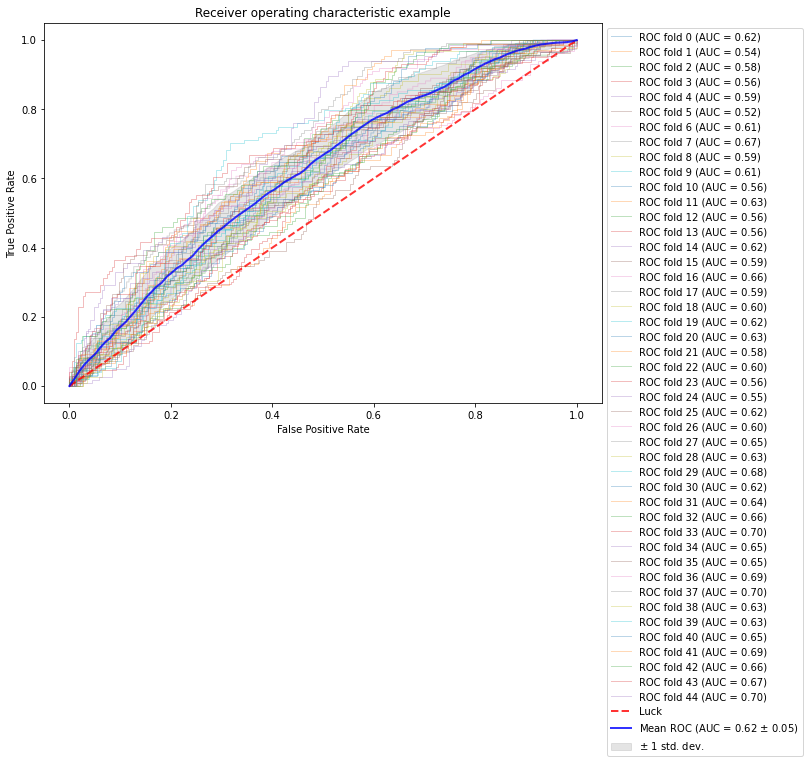

In [59]:
skf = CombPurgedKFoldCV(n_splits=10, n_test_splits= 2 ,embargo_td=pd.Timedelta(minutes=100))

classifier=DecisionTreeClassifier(criterion='entropy',max_features=1,max_depth=2,
                                  class_weight='balanced',min_weight_fraction_leaf=0.005)
classifier=BaggingClassifier(base_estimator=classifier,n_estimators=100,max_features=1.,
                             max_samples=avgU,oob_score=True,n_jobs=1)
crossValPlot2(skf,classifier,X,y,pred_times,eval_times)


In [60]:
from sklearn.model_selection import GridSearchCV
skf = CombPurgedKFoldCV(n_splits=10, n_test_splits= 2 ,embargo_td=pd.Timedelta(minutes=100))

In [61]:
clf = DecisionTreeClassifier()

In [62]:
classifier=BaggingClassifier(base_estimator=clf,oob_score=True,n_jobs=1)

In [63]:
classifier.get_params()

{'base_estimator': DecisionTreeClassifier(),
 'base_estimator__ccp_alpha': 0.0,
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': None,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [64]:
grid_param = [
              {'base_estimator__class_weight': ['balanced'],
               'base_estimator__criterion': ['gini', 'entropy'],
               'base_estimator__max_depth':[1,2,3,4,5,6],
               'base_estimator__max_features':[1,'auto'],
               'base_estimator__min_weight_fraction_leaf': [0.001, 0.005, 0.01],
               'base_estimator__random_state': [0],
               'base_estimator__splitter': ['best','random'],
               'n_estimators' : [50,100,500],
               'max_features': [1.0,2.0,3.0],
               'max_samples': [avgU,1.0],
               'n_estimators': [10,50,100,1000]         

}]


In [65]:
gs = GridSearchCV(estimator = classifier, param_grid = grid_param, scoring = 'f1',n_jobs = 1, cv=skf)

In [66]:
gs.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=<__main__.CombPurgedKFoldCV object at 0x7fa67ae98550>,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                         n_jobs=1, oob_score=True),
             n_jobs=1,
             param_grid=[{'base_estimator__class_weight': ['balanced'],
                          'base_estimator__criterion': ['gini', 'entropy'],
                          'base_estimator__max_depth': [1, 2, 3, 4, 5, 6],
                          'base_estimator__max_features': [1, 'auto'],
                          'base_estimator__min_weight_fraction_leaf': [0.001,
                                                                       0.005,
                                                                       0.01],
                          'base_estimator__random_state': [0],
                          'base_estimator__splitter': ['best', 'random'],
                          'max_features': [1.0, 2

In [ ]:
idx = pd.IndexSlice
max_depth = [1,2]
criterions = ['gini', 'entropy']
min_weight_fraction_leaf = [0.001, 0.005, 0.01]
n_estimators = [50,100,1000]
max_features = [1,'auto']
bagging_max_features = [1,2,3]
avg_scores = {}
for depth in max_depth:
  param = {"base_estimator__max_depth": depth ,
           'base_estimator__class_weight': 'balanced',
           }
  classifier.set_params(**param)
  for criterion in criterions:
    param = {"base_estimator__max_depth": depth ,
           'base_estimator__class_weight': 'balanced',
           'base_estimator__criterion': criterion,
           }
    classifier.set_params(**param)
    for leaf in min_weight_fraction_leaf:
      param = {"base_estimator__max_depth": depth ,
           'base_estimator__class_weight': 'balanced',
           'base_estimator__criterion': criterion,
           'base_estimator__min_weight_fraction_leaf': leaf
           }
      classifier.set_params(**param)
      for max_feat in max_features:
        param = {"base_estimator__max_depth": depth ,
           'base_estimator__class_weight': 'balanced',
           'base_estimator__criterion': criterion,
           'base_estimator__min_weight_fraction_leaf': leaf,
           'base_estimator__max_features': max_feat
           }
        classifier.set_params(**param)
        fold = 0
        for bmax_feat in bagging_max_features:
          param = {"base_estimator__max_depth": depth ,
           'base_estimator__class_weight': 'balanced',
           'base_estimator__criterion': criterion,
           'base_estimator__min_weight_fraction_leaf': leaf,
           'base_estimator__max_features': max_feat,
           'max_features': bmax_feat
           }
          classifier.set_params(**param)
          fold = 0
          for n_est in n_estimators:
            param = {"base_estimator__max_depth": depth ,
                     'base_estimator__class_weight': 'balanced',
                     'base_estimator__criterion': criterion,
                     'base_estimator__min_weight_fraction_leaf': leaf,
                     'base_estimator__max_features': max_feat,
                     'max_features': bmax_feat,
                     'n_estimators': n_est
                     }
            classifier.set_params(**param)
            fold = 0
            for train, test in skf.split(X, y, pred_times, eval_times):
              fold = fold + 1
              cie = classifier.fit(X.iloc[idx[train]], y.iloc[idx[train]])
              avg_scores['Depth:'+ str(depth) +
                       '_Fold:' + str(fold)+
                       '_' + criterion +
                       '_Max_feature_tree:' + str(max_feat) +
                       '_Max_feature_bagg:' + str(bmax_feat) +
                       '_Min_weight_frac_leaf' + str(leaf) +
                       '_N_estimators:' + str(n_est)] = cie.score(X.iloc[idx[train]], y.iloc[idx[train]])

          
          
          

In [ ]:
df = pd.DataFrame(data=avg_scores.values(), index = avg_scores.keys(),columns = ['OOB_Score'])
df.loc[df['OOB_Score'] == df['OOB_Score'].max()]

,OOB_Score
Depth:2_Fold:30_gini_Max_feature_tree:1_Max_feature_bagg:1_Min_weight_frac_leaf0.001_N_estimators:1000,0.927374
Depth:2_Fold:30_gini_Max_feature_tree:auto_Max_feature_bagg:1_Min_weight_frac_leaf0.005_N_estimators:1000,0.927374


In [ ]:
df.to_csv('Hyper_parameter_results.csv')
!cp Hyper_parameter_results.csv "gdrive/My Drive/TFM/Hyper_parameter_results.csv"